# Bericht und Code zum Beleg Maschinelles Lernen


Name: Quang Anh Nguyen



### Gliederung

* [Einführung](#Einführung)
* [Vorverarbeitung](#Vorverarbeitung)
  * [Bibliothek importieren](#Bibliothek-importieren)
  * [Daten laden](#Daten-laden)
  * [Features extraction](#Features-extraction)
      * [Erklärung zu CountVectorizer](#Erklärung-zu-CountVectorizer)
      * [Erklärung zu TfidfTransformer](#Erklärung-zu-TfidfTransformer)
  * [Feature reduction](#Feature-reduction)
      * [Stop word](#Stop-word)
      * [Lemmatization](#Lemmatization)
  * [Feature selection mit Mutual Information](#Feature-selection-mit-Mutual-Information)
* [Processing](#Processing)
   * [Logistic Regression](#Logistic-Regression)
   * [MultinomialNB](#MultinomialNB)
   * [Pipelines](#Pipelines)
   
* [Evaluation auf der Validation-Menge](#Evaluation-auf-der-Validation-Menge)
    * [Voting Gewichtung](#Voting-Gewichtung)
    * [Performance](#Performance)
    * [ROC-Kurve und AUC Score](#ROC-Kurve-und-AUC-Score)
* [Evaluation auf der Testmenge](#Evaluation-auf-der-Testmenge)
* [Literaturverzeichnis](#Literaturverzeichnis)

## Einführung

Wir haben 4651 Artikeln mit entsprechenden Etiketten(labels), die in einem .csv Datei gespeichert ist. Die Etikette besitzt den Wert 1 oder 0. Die Bedeutung von der Klassen ist unklar. Aber unsere Aufgabe ist es, ein Binärklassifikator-Modell zu bauen.

## Vorverarbeitung

### Bibliotheken importieren

In [17]:
import pandas as pd
import numpy as np
import sklearn
import nltk

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
 
from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.calibration import CalibratedClassifierCV

from nltk import word_tokenize     
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import plot_confusion_matrix


## Daten laden

Erstmal werden die csv- Datei importieren.
Die Daten von Spalte "title" und "text" wurden auf X gesetzt
Die Daten von Spalte "label" wurden auf y gesetzt

In [18]:
df = pd.read_csv('data_beleg.csv', encoding='utf-8').replace('\d+', 'NUM', regex=True)
df.columns = ['id','title','text','label']
df.head()
X = df['title']+ df['text']
y = df['label']

## Features extraction

##### Erklärung zu CountVectorizer
Durch  die Klasse CountVectorizer werden die Daten auf einzelne Wörte tokenisiert. Die Anzahl der Vorkommen von allen Wörten wird gezählt und in einem Matrix gespeichert.

In [19]:
countVectorizer = CountVectorizer().fit_transform(X)

##### Erklärung zu TfidfTransformer


Tf bedeutet Termfrequenz(Vorkommenshäufigkeit), tf-idf Termfrequenz mal inverse Dokumentfrequenz bedeutet.

Die Tf-Idf Nummer ist eine numerische Statistik, die widerspiegeln soll, wie wichtig ein Wort für ein Dokument in einer Sammlung.

In einem großen Textkorpus sind einige Wörter sehr vorhanden (z. B. "the", "a", "is" auf Englisch) und enthalten daher nur sehr wenige aussagekräftige Informationen über den tatsächlichen Inhalt des Dokuments. Wenn wir die direkten Zähldaten direkt einem Klassifikator zuführen würden, würden diese sehr häufigen Begriffe die Häufigkeit seltener, aber interessanterer Begriffe beschatten.

Um die Zählmerkmale in Gleitkommawerte umzuwandeln, die für die Verwendung durch einen Klassifizierer geeignet sind, wird häufig die tf-idf-Transformation verwendet.


Unter Verwendung der Standardeinstellungen des TfidfTransformer wird TfidfTransformer (norm = 'l2', use_idf = True, glatt_idf = True, sublinear_tf = False) die Termhäufigkeit, die Häufigkeit, mit der ein Term in einem bestimmten Dokument vorkommt, mit der IDF-Komponente multipliziert berechnet als:

\begin{align}
\text{idf}(t) = \log{\frac{1 + n}{1+\text{df}(t)}} + 1
\end{align}

n ist die Gesamtzahl der Dokumente im Dokumentensatz 
df(t) die Anzahl der Dokumente im Dokumentensatz, die einen Begriff(term) enthalten.

\begin{align}
\text{tf-idf(t,d)}=\text{tf(t,d)} \times \text{idf(t)}
\end{align}

### Feature reduction

Um einen effektiven Klassifikator zu bauen, muss die Anzahl von Features reduziert werden.

##### Stop word
Stop word sind Wörter, die sehr populär in einer Sprache sind und den Inhalt eines Textes nicht informativ darstellen wie “and”, “the”, “him”. Diese Wörte können entfernt werden , um zu vermeiden, dass sie als Signal für die Vorhersage ausgelegt werden. 

Manchmal sind jedoch ähnliche Wörter für die Vorhersage nützlich, beispielsweise bei der Klassifizierung des Schreibstils oder der Persönlichkeit.

Im folgenden Beispiel kann man sehen, dass die Anzahl von Wörtern deutlich reduziert werden.

In [20]:
cvWithSW = CountVectorizer(stop_words='english')
X_vec = cvWithSW.fit_transform(X)
print(len(cvWithSW.vocabulary_))


cvWithoutSW = CountVectorizer()
X_vec = cvWithoutSW.fit_transform(X)
print(len(cvWithoutSW.vocabulary_))

67668
67979


#### Lemmatization 

Lemmatization  ist der Prozess der Umwandlung eines Wortes in seine Grundform.

Wordnet ist eine große, frei und öffentlich verfügbare lexikalische Datenbank für die englische Sprache, die darauf abzielt, strukturierte semantische Beziehungen zwischen Wörtern herzustellen.

Im folgenden Beispiel kann man sehen, dass die Anzahl von Wörtern sehr stark reduziert werden.


In [21]:
from nltk.corpus import stopwords

class LemmaTokenizer:
    def __init__(self):
         self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
        
cvWithLemmatization = CountVectorizer(tokenizer = LemmaTokenizer())
X_vec = cvWithLemmatization.fit_transform(X)
print(len(cvWithLemmatization.vocabulary_))


cvWithoutSW = CountVectorizer()
X_vec = cvWithoutSW.fit_transform(X)
print(len(cvWithoutSW.vocabulary_))

63778
67979


 ##### TfidfVectorizer 
 beinhaltet CountVectorizer und TfidfTransformer.
 Um die Daten nutzbar machen, muss man sie vektorisieren.

In [22]:
vectorizer = TfidfVectorizer(tokenizer= LemmaTokenizer(), 
                             min_df= 0.01, max_df=0.5,
                                sublinear_tf=True, 
                                  norm='l2',  ngram_range=(1, 2), 
                                  stop_words='english' )

## Feature selection mit Mutual Information

Durch die Klasse "sklearn.feature_selection.mutual_info_classif" werden die gegenseitige Information für eine diskrete Zielvariable abgeschätzt. 

Im Zusammenhang mit der Selektor "SelecKBest" kann man nur die k- Features (Wörte) selektieren, die mit höchster Punktzahl sind. 
SelectKBest(score_func=mutual_info_classif, k=1000).fit_transform(X, y)

Hier sind die Wörter, die größeten Überraschungswert haben.  

In [23]:
countVectorizer = CountVectorizer(tokenizer = LemmaTokenizer(), min_df=0.01, stop_words='english')
X_vec = countVectorizer.fit_transform(X).toarray()
res = dict(zip(countVectorizer.get_feature_names(),
               mutual_info_classif(X_vec, y, discrete_features=True)))
sortdict = sorted(res.items(), key=lambda x: x[1]) [:15]   
print(sortdict)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


[('weren', 4.825383977773157e-07), ('particular', 2.672577304889661e-06), ('closely', 4.216853359515892e-06), ('gone', 5.51746104575845e-06), ('specifically', 5.6988465387229625e-06), ('checking', 1.5735769059723034e-05), ('terrible', 1.7296629689487596e-05), ('speaking', 2.4212539816426387e-05), ('calm', 4.050239691795986e-05), ('elegant', 4.4032532348560255e-05), ('wanting', 4.7437372840871024e-05), ('suggests', 5.264266087417796e-05), ('knowing', 5.3796451510287543e-05), ('resulting', 5.403779055069722e-05), ('visible', 6.747192435909571e-05)]


## Processing

Datensatz aufteilen.

80% des Datensatz für das Training
20% des Datensatz für den Test (Validierung)

In [24]:
X = vectorizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### Logistic Regression

Logistic Regression ist ein Klassifizierungsalgorithmus für maschinelles Lernen, mit dem die Wahrscheinlichkeit einer kategorial abhängigen Variablen vorhergesagt wird. Bei der logistischen Regression ist die abhängige Variable eine binäre Variable, die Daten enthält, die als 1 (Ja, Erfolg usw.) oder 0 (Nein, Fehler usw.) codiert sind. Mit anderen Worten, das logistische Regressionsmodell sagt P (Y = 1) als Funktion von X voraus.

#### Formale Definition
Wie bei der linearen Regression sucht man geeignete Koeffizienten (w), sodass man das Modell mit der folgenden Formel beschreiben kann:

y = w0 + w1*x1 + w2*x2 + ... + wn*xn

Dies liefert eine die beliebig große oder kleine Zahl, die gar nichts mit Wahrscheinlichkeiten zu tun hat. Um eine Wahrscheinlichkeit zu erhalten benötigen wir eine Zahl zwischen 0 und 1, die wir mit der logistischen Funktion errechnen.


### MultinomialNB

Naiver Bayes-Klassifikator für multinomiale Modelle

Der multinomiale Naive Bayes-Klassifikator eignet sich zur Klassifizierung mit diskreten Merkmalen. Die multinomiale Verteilung erfordert normalerweise ganzzahlige Merkmalszahlen. In der Praxis können jedoch auch Bruchzählungen wie tf-idf funktionieren.

MultinomialNB implementiert den naiven Bayes-Algorithmus für multinomial verteilte Daten und ist eine der beiden klassischen naiven Bayes-Varianten, die bei der Textklassifizierung verwendet werden

  Die Verteilung wird durch Vektoren für jede Klasse parametrisiert, wobei die Anzahl der Merkmale (bei der Textklassifizierung die Größe des Vokabulars) und die Wahrscheinlichkeit des Auftretens von Merkmalen in einer zur Klasse gehörenden Stichprobe angegeben werden.


\begin{align}
\hat{\theta}_{yi} = \frac{ N_{yi} + \alpha}{N_y + \alpha n}
\end{align}

### Pipelines

Mit der Pipeline können mehrere Schätzer zu einem verkettet werden.

Dies ist nützlich, da es häufig eine feste Abfolge von Schritten bei der Verarbeitung der Daten gibt, beispielsweise Merkmalsauswahl, Normalisierung und Klassifizierung. Die Pipeline dient hier mehreren Zwecken.

Zusammen mit GridsearchCV und VotingClassifier werden die best Klassifikator ausgewählt werden.


In [25]:
model1 = Pipeline([
    ('logreg', LogisticRegression())
])
 
model2 = Pipeline([
    ('mnb', MultinomialNB())
])
 
model3 = Pipeline([
    ('sgdc', CalibratedClassifierCV(SGDClassifier()))
])

classifiers = [
    ("model1", model1),
    ("model2", model2),
   ("model3", model3)
]
 
mixed_pipe = Pipeline([
    ("voting", VotingClassifier(classifiers, voting="soft"))
])


def combinations_on_off(num_classifiers):
    return [[int(x) for x in list("{0:0b}".format(i).zfill(num_classifiers))]
            for i in range(1, 2 ** num_classifiers)]
                           
                           
param_grid = dict(
    voting__weights=combinations_on_off(len(classifiers))
)


grid_search = GridSearchCV(mixed_pipe, param_grid=param_grid, n_jobs=-1, verbose=10, scoring="neg_log_loss")
 
grid_search.fit(X_train, y_train)

cv_results = grid_search.cv_results_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    8.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    8.8s finished


### Evaluation auf der Validation-Menge


#### Voting Gewichtung

Im Ergebnis lässt sich sagen, dass die einzelne Nutzung von Logistic Regression ist das beste Klassifikator-Modell.

In [26]:
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(params, mean_score)
 
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

y_pred = grid_search.predict(X_test)


probs = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc = auc(fpr, tpr)

{'voting__weights': [0, 0, 1]} -0.4921484270998908
{'voting__weights': [0, 1, 0]} -0.670891464286753
{'voting__weights': [0, 1, 1]} -0.448747041703787
{'voting__weights': [1, 0, 0]} -0.43566479803292496
{'voting__weights': [1, 0, 1]} -0.4563704557224021
{'voting__weights': [1, 1, 0]} -0.44249377151491276
{'voting__weights': [1, 1, 1]} -0.43895393089873735
Best score: -0.436
Best parameters set:
	voting__weights: [1, 0, 0]


#### Performance 

Die binäre Klassifizierung hat vier mögliche Arten von Ergebnissen:

Wahre Negative: korrekt vorhergesagte Negative (Nullen)
Echte Positive: korrekt vorhergesagte Positive (Einsen)
Falsch negative: falsch vorhergesagte Negative (Nullen)
False Positives: Falsch vorhergesagte Positive (Einsen)

[[385  52]
 [ 98 396]]


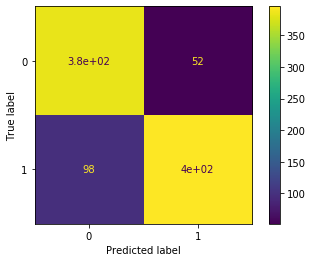

(931,)


In [27]:
print(confusion_matrix(y_test,y_pred))

plot_confusion_matrix(grid_search, X_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

print(y_test.shape)

### ROC-Kurve und AUC Score

In [28]:
print("AUC score:",accuracy_score(y_test, y_pred))

AUC score: 0.8388829215896885


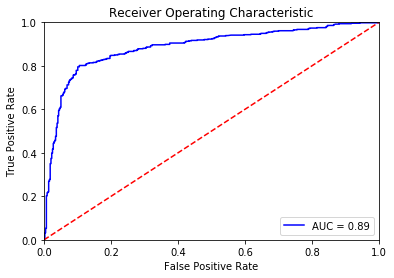

In [29]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Evaluation auf der Testmenge

In [30]:
# Da Sie das Test-Set nicht haben, Führen Sie dies mit den ursprünglichen Daten durch:
df_test = pd.read_csv('data_beleg.csv', encoding='utf-8')
# Wird von mir ersetzt durch
# df_test = pd.read_csv('data_test.csv', encoding='utf-8')
# und sollte dann auch durchlaufen!

In [ ]:
eval_x = df_test['text']+ df_test['title']
eval_x = vectorizer.transform(eval_x)
eval_y_test_true = df_test['label']

In [ ]:
# Wenden Sie hier ihre Vorverarbeitung/Klassifikation ihres entgültigen Modells 
# an. 

# In dieser Variable sollte die Vorhersagewahrscheinlichkeit für die positive Klasse
# p(y=1 | x) gespeichte sein.
y_test_prob_class_1 = grid_search.predict_proba(eval_x)[:,1]

In [ ]:
evaluate = roc_auc_score(eval_y_test_true, y_test_prob_class_1)
print("evaluate:",evaluate)

### Literaturverzeichnis



https://de.wikipedia.org/wiki/Tf-idf-Ma%C3%9F

https://www.datacamp.com/community/tutorials/stemming-lemmatization-python

https://www.machinelearningplus.com/nlp/lemmatization-examples-python

https://www.ancud.de/logistische-regression-mit-python-und-exploratorische-datenanalyse/

https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction